# Economic activity and carbon emissions

This notebook studies the US GDP output and carbon emissions at the quarterly frequency. 

## First, quartely GDP data. 

This is the highest frequency at which economic data can be easily obtained.  
The focus in this notebook is on the **United States**.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt          # Library for visualization


url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GDP&scale=left&cosd=1947-01-01&coed=2021-04-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-09-17&revision_date=2021-09-17&nd=1947-01-01'
data_gdp = pd.read_csv(url)
data_gdp.DATE = pd.to_datetime(data_gdp.DATE)
data_gdp

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742
...,...,...
293,2020-04-01,19477.444
294,2020-07-01,21138.574
295,2020-10-01,21477.597
296,2021-01-01,22038.226


One important precision: each date is associated to its quarter. So January corresponds to the whole Q1 of a given year.

## High frequency carbon emissions

Second, we fetch daily (!) emissions from carbonmonitor.

In [14]:
url = 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global'
data_carbon = pd.read_csv(url, skiprows = 0)
data_carbon['date'] = pd.to_datetime(data_carbon['date'],format='%d/%m/%Y') # Correct date format
# Below, we switch to capital letters for 1st character of column names
data_carbon = data_carbon.rename(columns={'country': 'Country', 
                                          'date': 'Date', 
                                          'sector': 'Sector', 
                                          'value': 'Value', 
                                          'timestamp': 'Timestamp'})
data_carbon['Year'] = data_carbon.Date.dt.year
data_carbon['Quarter'] = data_carbon.Date.dt.quarter
data_carbon

,Country,Date,Sector,Value,Timestamp,Year,Quarter
0,Brazil,2019-01-01,Power,0.108768,1546272000,2019,1
1,China,2019-01-01,Power,14.251000,1546272000,2019,1
2,EU27 & UK,2019-01-01,Power,1.676910,1546272000,2019,1
3,France,2019-01-01,Power,0.049075,1546272000,2019,1
4,Germany,2019-01-01,Power,0.349691,1546272000,2019,1
...,...,...,...,...,...,...,...
79207,Russia,2021-07-31,International Aviation,0.027206,1627660800,2021,3
79208,Spain,2021-07-31,International Aviation,0.058840,1627660800,2021,3
79209,UK,2021-07-31,International Aviation,0.055172,1627660800,2021,3
79210,US,2021-07-31,International Aviation,0.164318,1627660800,2021,3


We aim to look at simple series. We need to:
- restrict the data to the US;  
- aggregate all sources of emissions (sectors) via a pivot table;  
- keep only quarterly points (first days of January, April, July and October) - this is automatic via joining.

In [28]:
data_carbon_q = data_carbon.query('Country == "US"').pivot_table(values = ['Value'], 
                                                 aggfunc = 'sum', 
                                                 index = ['Country', 'Year', 'Quarter']).reset_index()
data_carbon_q['Month'] = data_carbon_q['Quarter']*3 - 2
data_carbon_q['Day'] = 1
data_carbon_q['Date'] = pd.to_datetime(data_carbon_q[['Year', 'Month', 'Day']])
data_carbon_q

,Country,Year,Quarter,Value,Month,Day,Date
0,US,2019,1,1369.764584,1,1,2019-01-01
1,US,2019,2,1171.487597,4,1,2019-04-01
2,US,2019,3,1279.692947,7,1,2019-07-01
3,US,2019,4,1289.955988,10,1,2019-10-01
4,US,2020,1,1252.072139,1,1,2020-01-01
5,US,2020,2,973.091693,4,1,2020-04-01
6,US,2020,3,1176.178530,7,1,2020-07-01
7,US,2020,4,1192.272724,10,1,2020-10-01
8,US,2021,1,1262.279017,1,1,2021-01-01
9,US,2021,2,1149.591630,4,1,2021-04-01


In the pivot table, the values are those for the whole quarter that **succedes** to the Date column.   
This is an important point to keep in mind.   
We can now join the two sets.

In [30]:
data_merged = pd.merge(data_carbon_q,
                       data_gdp, 
                       left_on='Date', 
                       right_on='DATE')
data_merged

,Country,Year,Quarter,Value,Month,Day,Date,DATE,GDP
0,US,2019,1,1369.764584,1,1,2019-01-01,2019-01-01,21001.591
1,US,2019,2,1171.487597,4,1,2019-04-01,2019-04-01,21289.268
2,US,2019,3,1279.692947,7,1,2019-07-01,2019-07-01,21505.012
3,US,2019,4,1289.955988,10,1,2019-10-01,2019-10-01,21694.458
4,US,2020,1,1252.072139,1,1,2020-01-01,2020-01-01,21481.367
5,US,2020,2,973.091693,4,1,2020-04-01,2020-04-01,19477.444
6,US,2020,3,1176.178530,7,1,2020-07-01,2020-07-01,21138.574
7,US,2020,4,1192.272724,10,1,2020-10-01,2020-10-01,21477.597
8,US,2021,1,1262.279017,1,1,2021-01-01,2021-01-01,22038.226
9,US,2021,2,1149.591630,4,1,2021-04-01,2021-04-01,22731.369


And then plot!


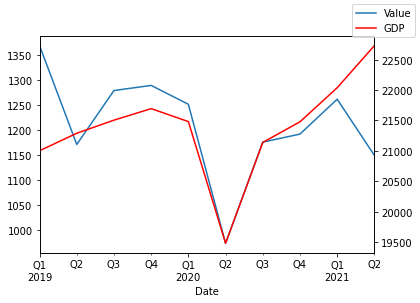

In [31]:
ax = data_merged.plot(x = "Date", y = "Value", legend = False)
ax2 = ax.twinx()
data_merged.plot(x = "Date", y = "GDP", ax = ax2, legend = False, color = "r")
ax.figure.legend()
plt.show()

The correspondence is not perfect, though the most important movements coincide, especially the *COVID* quarter of 2020 when the US was hit the hardest - at least economically. 